Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = 'recall_micro'

EXPERIEMENT_NAME = "offense_potential_predictor"
RUN_NAME = "1"

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']


In [2]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>84)
GROUP BY ID
order by potential DESC;
"""



In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,91.0,94.2,12.340000,-5.480000,23.148000,0.040000,26.380000,19.140000,30.320000,23.140000
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,93.5,92.2,10.272727,7.621212,25.527273,10.090909,25.606061,7.333333,30.212121,22.757576
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,79.5,80.2,4.923077,6.769231,8.369231,4.538462,5.538462,4.538462,11.153846,5.769231
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,86.5,83.0,6.950000,-1.975000,10.140000,5.200000,15.850000,16.600000,14.800000,13.300000
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,87.0,83.2,10.571429,0.357143,17.071429,10.857143,20.000000,7.071429,19.071429,6.000000


In [5]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'test', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<83)&(df.Age<26)&(df.Potential>83)]

In [6]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall>82
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.head()

target
False    149
True      89
Name: count, dtype: int64


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,set,target
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,12.340000,-5.480000,23.148000,0.040000,26.380000,19.140000,30.320000,23.140000,drop,True
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,10.272727,7.621212,25.527273,10.090909,25.606061,7.333333,30.212121,22.757576,drop,True
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,6.950000,-1.975000,10.140000,5.200000,15.850000,16.600000,14.800000,13.300000,drop,True
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,10.571429,0.357143,17.071429,10.857143,20.000000,7.071429,19.071429,6.000000,test,False
208790,Z. Bakkali,2014,17.0,17.0,https://cdn.sofifa.net/players/208/790/14_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,73.0,90.0,PSV,https://cdn.sofifa.net/meta/team/682/30.png,€2.1M,...,2.000000,-17.500000,12.866667,-4.666667,6.666667,15.333333,11.000000,6.333333,train,False


In [7]:
df_processed.best_position.value_counts()

best_position
ST    111
RW     50
LW     50
CF     21
RF      4
LF      2
Name: count, dtype: int64

In [8]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,True,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,True,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,True,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,False,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,False,train,RW


In [9]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [10]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

overall_age_ratio   -0.28
youth_player        -0.28
Defense             -0.10
Marking             -0.01
SlidingTackle       -0.01
                     ... 
Reactions            0.50
Overall              0.53
PrimeOverall         0.76
target               1.00
offense               NaN
Name: target, Length: 65, dtype: float64

In [11]:
df[df.Age<20].describe().round(0).compare(df[df.Age>=20].describe().round(0))

potential_age           Age        Overall        Potential         \
               self  other   self  other    self  other      self  other   
count         101.0  137.0  101.0  137.0   101.0  137.0     101.0  137.0   
mean           18.0   22.0   18.0   22.0    70.0   79.0       NaN    NaN   
std             1.0    2.0    1.0    2.0     5.0    4.0       1.0    2.0   
min            16.0   20.0   16.0   20.0    59.0   69.0       NaN    NaN   
25%            17.0   21.0   17.0   21.0    67.0   76.0       NaN    NaN   
50%            18.0   22.0   18.0   22.0    69.0   79.0      85.0   86.0   
75%            19.0   23.0   19.0   23.0    74.0   81.0       NaN    NaN   
max            19.0   25.0   19.0   25.0    81.0   90.0      91.0   95.0   

      Special          ... age_based_Stamina        age_based_Positioning  \
         self   other  ...              self  other                  self   
count   101.0   137.0  ...             101.0  137.0                 101.0   
mean   1705.0  1921.0  ...              -1.0    1.0                   6.0   
std     120.0   110.0  ...               6.0    7.0                   9.0   
min    1424.0  1584.0  ...             -17.0  -21.0                 -16.0   
25%    1626.0  1858.0  ...              -5.0   -3.0                   0.0   
50%    1697.0  1923.0  ...              -0.0    1.0                   5.0   
75%    1794.0  1982.0  ...               4.0    5.0                  11.0   
max    1979.0  2316.0  ...              16.0   20.0                  36.0   

             age_based_Vision        age_based_Finishing         \
       other             self  other                self  other   
count  137.0            101.0  137.0               101.0  137.0   
mean    13.0              0.0    3.0                 9.0   17.0   
std      8.0              NaN    NaN                 NaN    NaN   
min     -8.0            -22.0  -16.0               -12.0   -4.0   
25%      7.0             -4.0   -3.0                 3.0   12.0   
50%     13.0              0.0    3.0                 9.0   18.0   
75%     19.0              5.0    8.0                15.0   24.0   
max     30.0             17.0   19.0                40.0   38.0   

      age_based_BallControl         
                       self  other  
count                 101.0  137.0  
mean                    2.0    6.0  
std                     7.0    6.0  
min                   -11.0   -8.0  
25%                    -2.0    2.0  
50%                     1.0    5.0  
75%                     6.0    9.0  
max                    32.0   23.0  

[8 rows x 126 columns]

In [12]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
bool_age = df.Age == 20
df[df.target&bool_age].describe().round(3).compare(df[~df.target&bool_age].describe().round(0))



potential_age        Age       Overall       Potential         Special  \
               self other self other    self other      self other      self   
count           6.0  20.0  6.0  20.0   6.000  20.0     6.000  20.0     6.000   
mean            NaN   NaN  NaN   NaN  78.000  75.0    87.167  85.0  1910.000   
std             NaN   NaN  NaN   NaN   4.472   3.0     2.137   1.0    93.808   
min             NaN   NaN  NaN   NaN  74.000  69.0       NaN   NaN  1810.000   
25%             NaN   NaN  NaN   NaN  74.250  74.0    86.000  85.0  1838.000   
50%             NaN   NaN  NaN   NaN  77.000  75.0    86.500  85.0  1898.000   
75%             NaN   NaN  NaN   NaN  80.500  76.0    87.750  85.0  1958.000   
max             NaN   NaN  NaN   NaN  85.000  79.0    91.000  88.0  2058.000   

              Unnamed: 0          Crossing       Finishing        \
        other       self    other     self other      self other   
count    20.0      6.000     20.0    6.000  20.0     6.000  20.0   
mean   1831.0  12913.333  11719.0   67.667  66.0    75.833  70.0   
std      97.0   2929.691   1551.0    7.394   9.0     4.792   7.0   
min    1584.0   9136.000   9517.0   59.000  40.0    69.000  57.0   
25%    1777.0  11240.500  10475.0   62.500  65.0    75.000  64.0   
50%    1857.0  12393.000  11672.0   67.000  68.0    75.500  70.0   
75%    1868.0  14748.500  12618.0   71.500  69.0    76.000  74.0   
max    1998.0  17168.000  15881.0   79.000  77.0    84.000  82.0   

      HeadingAccuracy       ShortPassing       Volleys       Dribbling        \
                 self other         self other    self other      self other   
count           6.000  20.0        6.000  20.0   6.000  20.0     6.000  20.0   
mean           65.333  57.0       72.333  70.0  70.833  64.0    80.333  78.0   
std             9.374  12.0        6.346   5.0   6.242   9.0     9.688   5.0   
min            52.000  34.0       66.000  56.0  65.000  44.0    68.000  67.0   
25%            59.750  50.0          NaN   NaN  66.250  59.0    72.500  76.0   
50%            65.500  56.0       71.500  70.0  68.500  64.0    81.500  78.0   
75%            72.750  64.0       77.500  74.0  75.250  72.0    89.000  81.0   
max            76.000  83.0       80.000  79.0  80.000  81.0    90.000  86.0   

        Curve       FKAccuracy       LongPassing       BallControl        \
         self other       self other        self other        self other   
count   6.000  20.0       6.00  20.0       6.000  20.0       6.000  20.0   
mean   73.333  64.0      57.50  58.0      60.167  60.0      79.667  77.0   
std     8.430   7.0      17.74  12.0       9.218   9.0       8.524   4.0   
min    59.000  50.0      33.00  29.0      49.000  40.0      71.000  69.0   
25%    71.250  62.0      43.75  47.0      53.500  53.0      73.500  74.0   
50%    74.000  64.0      63.50  64.0         NaN   NaN         NaN   NaN   
75%    77.500  68.0      69.75  66.0      65.000  66.0      85.750  81.0   
max    84.000  74.0      76.00  75.0         NaN   NaN      92.000  84.0   

      Acceleration       SprintSpeed       Agility       Reactions        \
              self other        self other    self other      self other   
count        6.000  20.0       6.000  20.0   6.000  20.0     6.000  20.0   
mean        84.833  84.0      86.167  83.0     NaN   NaN    75.833  71.0   
std          7.910   8.0       6.113   6.0   8.672   9.0     5.307   5.0   
min         74.000  65.0      77.000  74.0  74.000  64.0    68.000  56.0   
25%         79.250  80.0      82.250  80.0  75.000  78.0    73.750  69.0   
50%         85.500  86.0      88.000  83.0  80.000  81.0    76.000  72.0   
75%         91.000  90.0      90.000  88.0  87.250  90.0    77.500  74.0   
max            NaN   NaN         NaN   NaN  95.000  92.0    84.000  80.0   

      Balance       ShotPower       Jumping       Stamina       Strength  \
         self other      self other    self other    self other     self   
count   6.000  20.0     6.000  20.0   6.000  20.0

###  Feature Engineering

#### Transform Value

In [13]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [14]:
df['target'].value_counts()

target
False    149
True      89
Name: count, dtype: int64

In [15]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [16]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [17]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [18]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [19]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [20]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# FINAL Model RUN

In [21]:
baseline_xgb = {'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.947262595858492,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.17306943534536462,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 5.487238368100121,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 178,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.8830533342293516,
 'reg_lambda': 0.08710531261301288,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9388760328915166,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# TODOS
- f1 Score für false Predictions
- save shap values für alle Modelle -> DONE
- plots in einem Ordner saven
- Random State hinzufügen -> DONE
- Vereinfachung des Codes -> Was kann man in der Riesenschleife als Function exportieren?


Decision Tree Classifier training----->


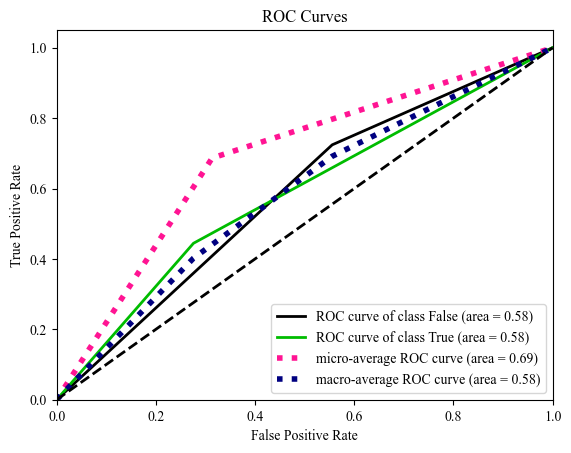

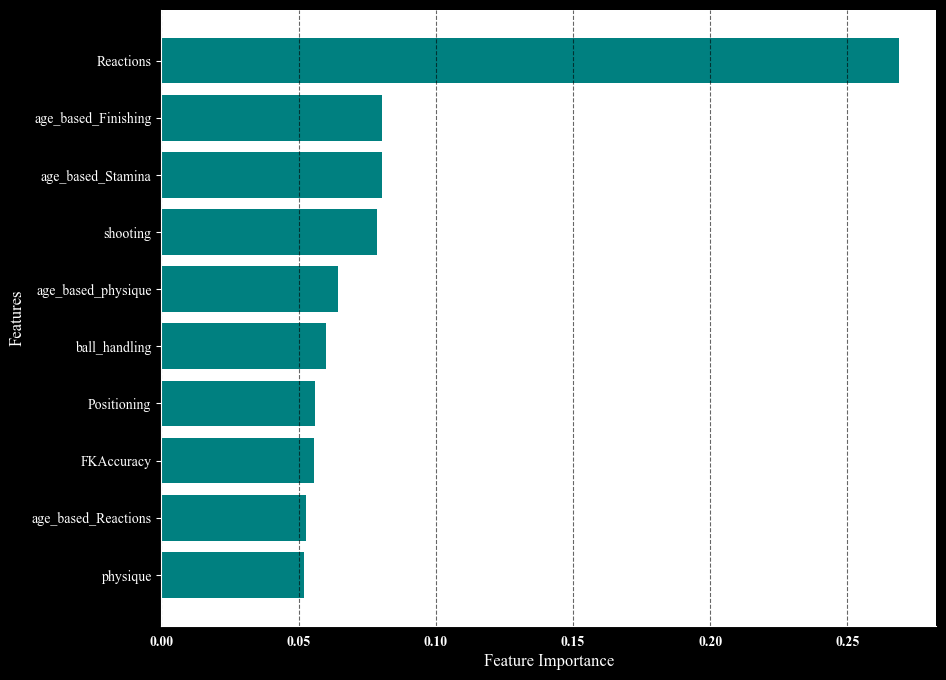

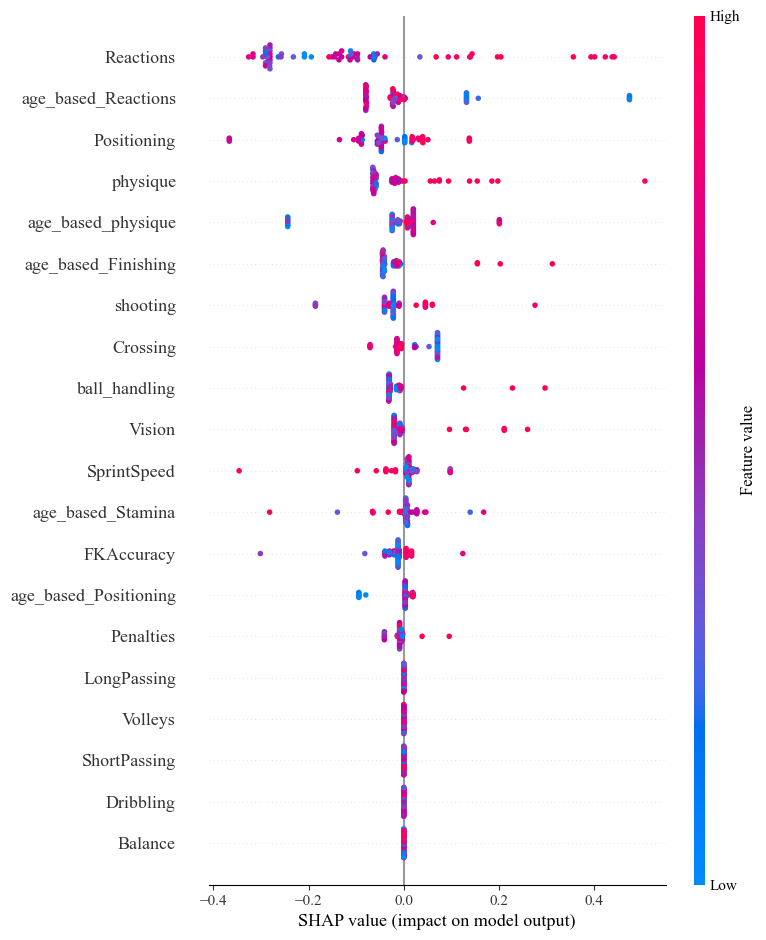

Random Forest Classifier training----->


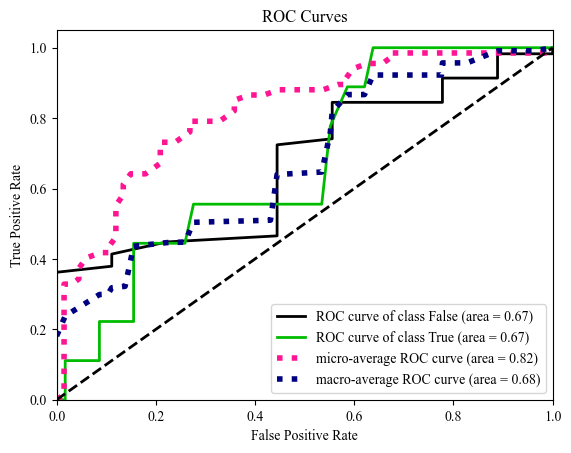

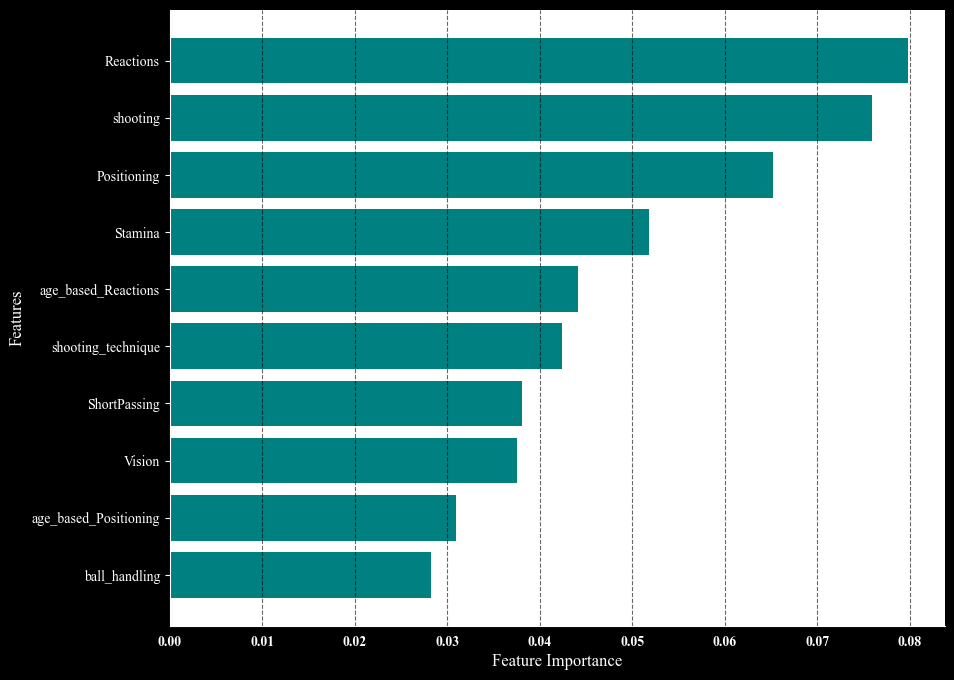

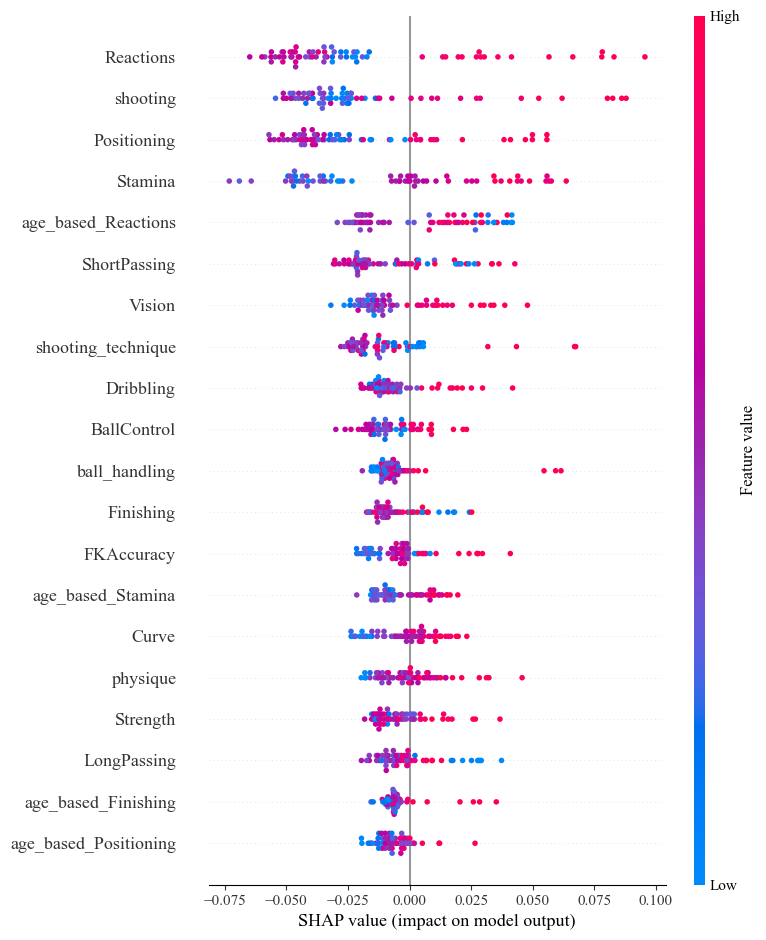

XGBoost Classifier training----->


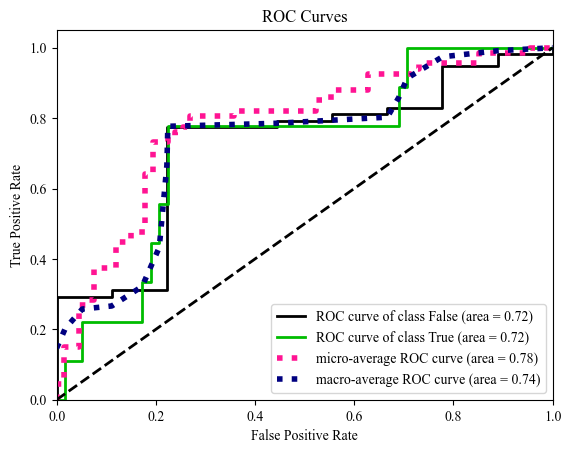

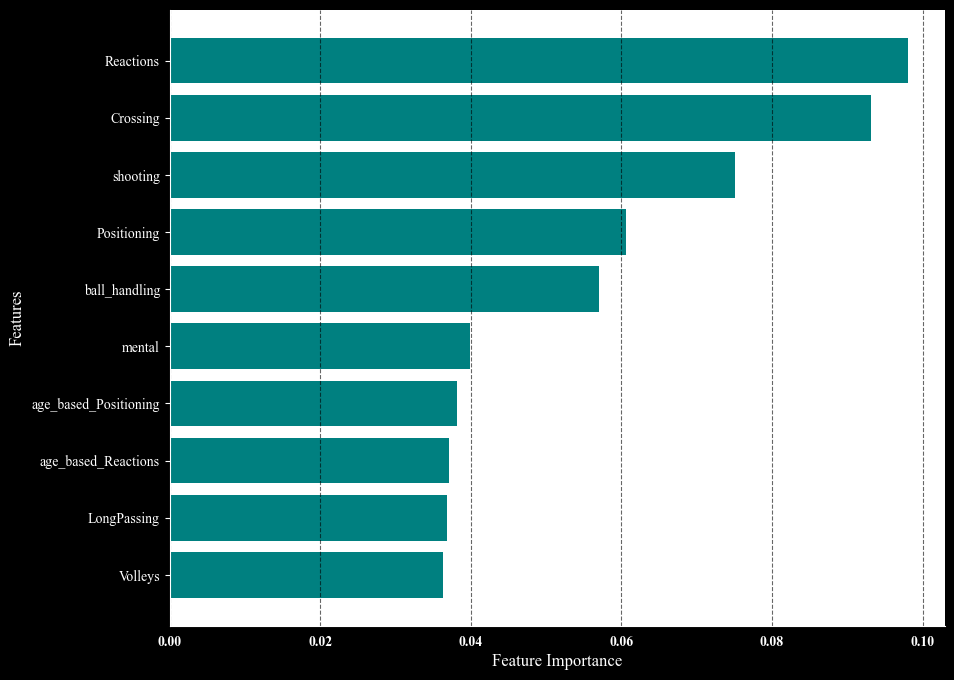

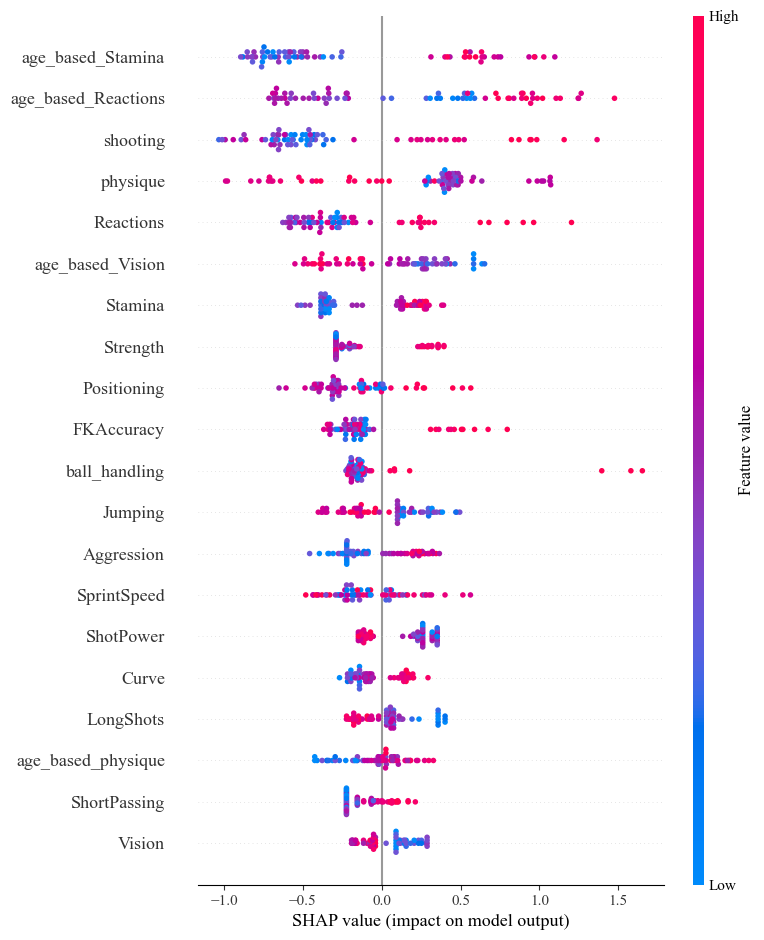

LightGBM Classifier training----->
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 42, number of negative: 51
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451613 -> initscore=-0.194156
[LightGBM] [Info] Start training from score -0.194156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

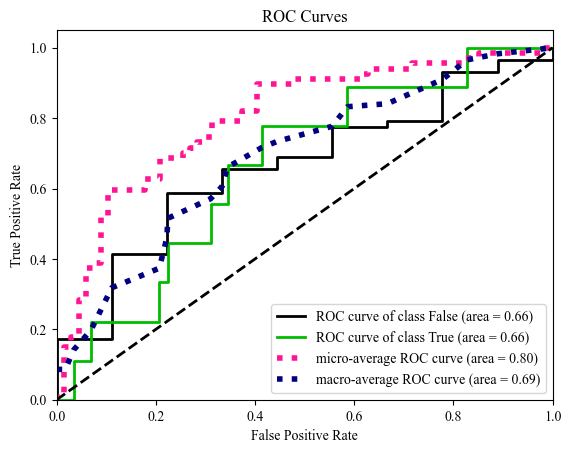

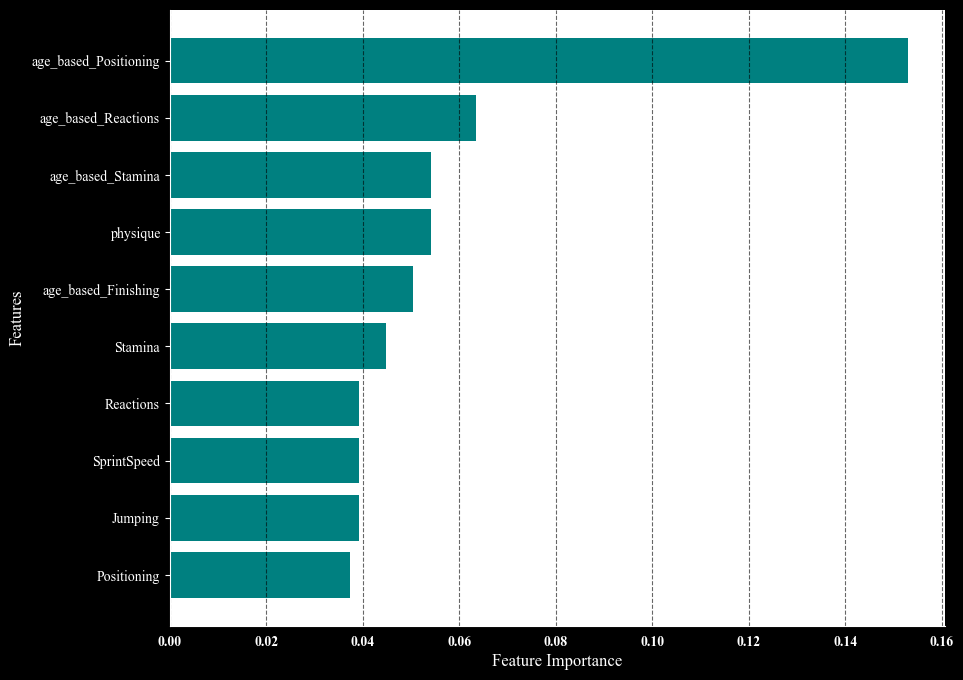

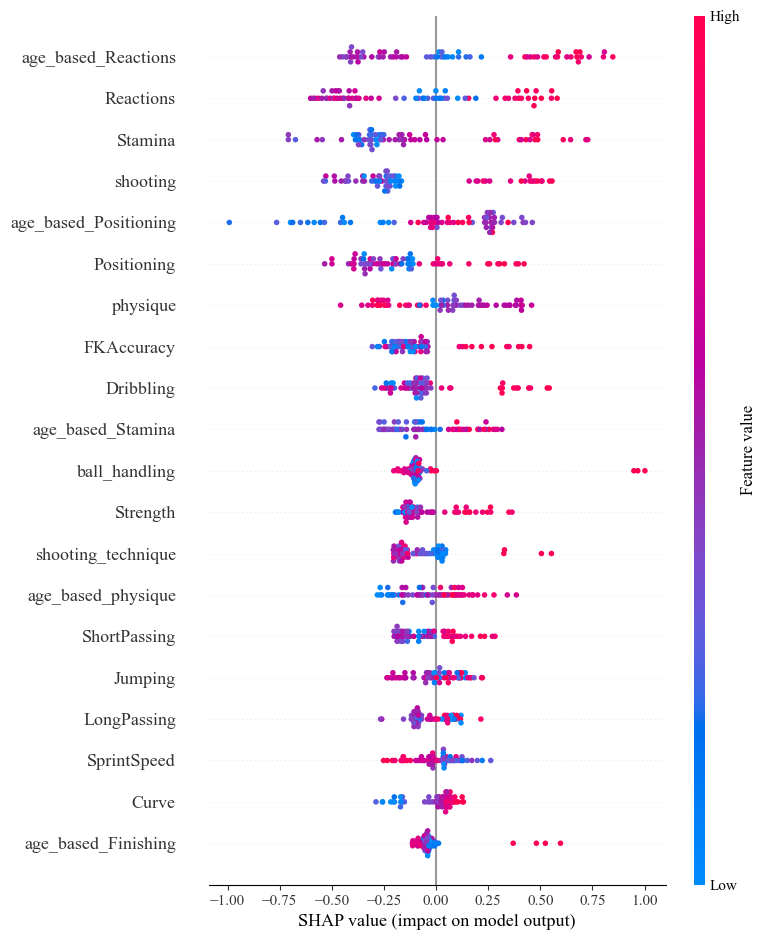

Model: Decision Tree Classifier
Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.72      0.80        58
        True       0.20      0.44      0.28         9

    accuracy                           0.69        67
   macro avg       0.55      0.58      0.54        67
weighted avg       0.80      0.69      0.73        67

Confusion Matrix:
[[42 16]
 [ 5  4]]
AUC: 0.58
Precision: 0.20

Model: Random Forest Classifier
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.81      0.85        58
        True       0.27      0.44      0.33         9

    accuracy                           0.76        67
   macro avg       0.59      0.63      0.59        67
weighted avg       0.82      0.76      0.78        67

Confusion Matrix:
[[47 11]
 [ 5  4]]
AUC: 0.67
Precision: 0.27

Model: XGBoost Classifier
Accuracy: 0.76
Classification Report:
              

In [23]:
import pandas as pd
import scikitplot as skplt
from sklearn.metrics import roc_curve, roc_auc_score,recall_score,f1_score
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import warnings
import pickle
from src.sport_analytics.model.eval import individual_shap_valuess,plot_feature_importance
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42,class_weight=class_weights, **PARAM_DT),
    'Random Forest Classifier': RandomForestClassifier(random_state=42,class_weight=class_weights, **PARAMS_RF),
    'XGBoost Classifier': xgb.XGBClassifier(random_state=42,**PARAM_XGB),
    # 'Support Vector Classifier': SVC(class_weight=class_weights, probability=True, kernel='linear'),
    # 'XGBoost Classifier': xgb.XGBClassifier(**PARAM_XGB),
    'LightGBM Classifier': lgb.LGBMClassifier(random_state=42,**{'n_estimators': 100, 'max_depth': 7, 'min_child_samples': 7,
                                                  'subsample': 0.8090291881142198, 'colsample_bytree': 0.6278496311554949,
                                                  'learning_rate': 0.17976777947590364, 'reg_alpha': 0.6699371890412207,
                                                  'reg_lambda': 1.5295937299896694})
}

model_results = {}

# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in models.items():
    with mlflow.start_run():

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)

        y_pred = model.predict(X_test_scaled_df)

        # Eval
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
        else:
            y_prob = None
            
        plot_auc_curves(y_true = y_test,y_proba = model.predict_proba(X_test_scaled_df))
        plot_feature_importance(model, '')
        plot_shap_summary(model=model,df=X_test_scaled_df)
 

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        # Assuming y_test and y_pred are defined

        precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_pred)
        area_under_curve_pr = auc(recall_array, precision_array)
        if y_prob is not None:
            roc_auc = roc_auc_score(y_test, y_prob)
        else:
            roc_auc = None

        
        # Calculate macro and micro scores
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

        # Calculate precision, recall, and F1 for both positive and negative classes
        precision_pos, recall_pos, f1_pos, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average='binary')
        precision_neg, recall_neg, f1_neg, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0], average='binary')

        # Log metrics
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("AUC", roc_auc)
        mlflow.log_metric("PR_AUC", area_under_curve_pr)
        # mlflow.log_metric("Precision", precision)
        # mlflow.log_metric("Recall", recall)
        # mlflow.log_metric("F1", f1)

        mlflow.log_metric("Precision_Macro", precision_macro)
        mlflow.log_metric("Recall_Macro", recall_macro)
        mlflow.log_metric("F1_Macro", f1_macro)

        mlflow.log_metric("Precision_Micro", precision_micro)
        mlflow.log_metric("Recall_Micro", recall_micro)
        mlflow.log_metric("F1_Micro", f1_micro)

        mlflow.log_metric("Precision_Positive", precision_pos)
        mlflow.log_metric("Recall_Positive", recall_pos)
        mlflow.log_metric("F1_Positive", f1_pos)

        mlflow.log_metric("Precision_Negative", precision_neg)
        mlflow.log_metric("Recall_Negative", recall_neg)
        mlflow.log_metric("F1_Negative", f1_neg)

        mlflow.log_param('HYPERTRAINING', HYPERTRAINING)
        mlflow.log_param('CV', CV)
        mlflow.log_param('SCORING', SCORING)
        mlflow.log_param('features_anzahl', len(PLAYER_ATTRIBUTES))
        mlflow.log_param('y_train_positives', y_train.sum())
        mlflow.log_param('y_train_negatives', (~y_train).sum())
        mlflow.log_param('y_test_positives', y_test.sum())
        mlflow.log_param('y_test_negatives', (~y_test).sum())

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        model_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': PLAYER_ATTRIBUTES,
            'Accuracy': accuracy,
            'Classification Report': report,
            'Confusion Matrix': conf_matrix,
            'AUC': roc_auc,
            'PR_AUC': area_under_curve_pr,
            'recall':recall_pos,
            'f1':f1_pos,
            'Precision': precision_pos
        }


# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


# evaluate Model

In [ ]:
false_positives = (my_model.predict_proba(X_test_scaled_df)[:,1]>0.5)&(~y_test)
X_test_scaled_df[false_positives]



In [ ]:
false_negatives = (my_model.predict_proba(X_test_scaled_df)[:,1]<0.4)&(y_test)
X_test_scaled_df[false_negatives]